## 3 线性神经网络

### 3.1 线性回归

问题定义：

$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
$$

损失函数：

$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$

$$
\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b)
$$

解析解：

$$
\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}
$$



本书中我们用到一种名为梯度下降（gradient descent）的方法， 这种方法几乎可以优化所有深度学习模型。 它通过不断地在损失函数递减的方向上更新参数来降低误差。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

在每次迭代中，我们首先随机抽样一个小批量$\Beta$， 它是由固定数量的训练样本组成的。 然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。 最后，我们将梯度乘以一个预先确定的正数 $\eta$，并从当前参数的值中减掉。

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$

总结一下，算法的步骤如下：

1. 初始化模型参数的值，如随机初始化； 
2. 从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。 

对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$
\begin{split}\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}\end{split}
$$


#### 3.1.2 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。为了实现这一点，需要我们对计算进行矢量化， 从而利用线性代数库，而不是在Python中编写开销高昂的for循环。


In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [3]:
# 定义一个计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
# 测试for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

0.08000 sec


In [5]:
# 矩阵重载符号+
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

#### 3.1.3 正态分布与平方损失

接下来，我们通过对噪声分布的假设来解读平方损失目标函数。

正态分布公式：

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)
$$

In [6]:
#定义一个函数计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

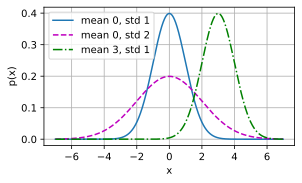

In [7]:
# 再次使用numpy进行可视化
import utils
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
utils.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

均方误差损失函数假设的公式：

$$
y = \mathbf{w}^\top \mathbf{x} + b + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的似然（likelihood）：

$$
P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).
$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的似然最大的值：

$$
P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).
$$

根据极大似然估计法选择的估计量称为极大似然估计量。 虽然使许多指数函数的乘积最大化看起来很困难， 但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。 由于历史原因，优化通常是说最小化而不是最大化。 我们可以改为最小化负对数似然$-\log P(\mathbf y \mid \mathbf X)$。 由此可以得到的数学公式是：

$$
-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.
$$

In [8]:
### 3.2 线性回归的从零开始实现

In [9]:
%matplotlib inline
import random
import torch

#### 3.2.1 生成数据集

In [10]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.6052, -0.0517]) 
label: tensor([1.1605])


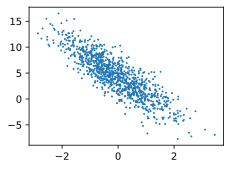

In [11]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2 线性回归的从零开始实现

In [12]:
%matplotlib inline
import random
import torch
import utils

#### 3.2.1 生成数据集

我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$ , $b = 4.2$ 和噪声项 $\epsilon$

$$
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.
$$

标准差为0.01

In [13]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.4346, 0.5506]) 
label: tensor([5.2043])


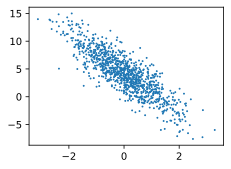

In [15]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

#### 3.2.2 读取数据集

打乱数据集中的样本并以小批量方式获取数据

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2377, -0.2362],
        [ 0.9160, -0.4314],
        [-0.4741, -0.3405],
        [ 0.8168, -0.4050],
        [-1.3411,  0.0739],
        [-0.7305,  2.0049],
        [-0.6690, -0.5326],
        [ 0.3190, -0.3166],
        [-1.6206, -1.4117],
        [-0.8459, -0.5443]]) 
 tensor([[ 5.4741],
        [ 7.5013],
        [ 4.3993],
        [ 7.2042],
        [ 1.2599],
        [-4.0675],
        [ 4.6774],
        [ 5.9141],
        [ 5.7595],
        [ 4.3517]])


#### 3.2.3 初始化模型参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0

In [18]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### 3.2.4 定义模型

In [19]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 3.2.5 定义损失函数

In [20]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 3.2.6 定义优化算法

小批量随机梯度下降

In [21]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 3.2.7 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。 理解这段代码至关重要，因为从事深度学习后， 相同的训练过程几乎一遍又一遍地出现。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

概括一下，我们将执行以下循环：

- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  - 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 我们现在忽略这些细节，以后会在 11节中详细介绍。

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043592
epoch 2, loss 0.000165
epoch 3, loss 0.000048


In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-5.0783e-05, -6.9237e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


### 3.3 线性回归的简洁实现

In [24]:
# 生成数据集

import numpy as np
import torch
from torch.utils import data
import utils

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [25]:
# 读取数据集

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
# 取数据

next(iter(data_iter))

[tensor([[-0.4036,  2.6274],
         [ 0.6824, -0.6393],
         [-0.4870, -0.3925],
         [-1.1985,  0.6055],
         [-0.9591, -0.9914],
         [ 0.7107,  1.2250],
         [ 0.7558,  0.3351],
         [-0.0252,  0.7142],
         [ 0.3890, -0.8177],
         [ 0.4153, -1.6836]]),
 tensor([[-5.5568],
         [ 7.7478],
         [ 4.5909],
         [-0.2721],
         [ 5.6556],
         [ 1.4556],
         [ 4.5970],
         [ 1.7269],
         [ 7.7562],
         [10.7594]])]

In [27]:

# 定义模型

# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [28]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [29]:
# 定义损失函数
loss = nn.MSELoss()

In [30]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [31]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000284
epoch 2, loss 0.000100
epoch 3, loss 0.000101


In [32]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0006, -0.0009])
b的估计误差： tensor([0.0006])


### 3.4 softmax回归

分类问题

$\{\text{狗}, \text{猫}, \text{鸡}\}$ 类似的分类问题

#### 3.4.2 网络架构

为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。 为了解决线性模型的分类问题，我们需要和输出一样多的仿射函数（affine function）。 每个输出对应于它自己的仿射函数。 在我们的例子中，由于我们有4个特征和3个可能的输出类别， 我们将需要12个标量来表示权重（带下标的）$w$ ， 3个标量来表示偏置（带下标的）。 下面我们为每个输入计算三个未规范化的预测（logit）： $o_1$ 、 $o_2$ 和 $o_3$。

$$
\begin{split}\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}\end{split}
$$

![softmax](img/softmax.png)

通过向量形式表达为

$$
\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

#### 3.4.3 全连接层的参数开销

全连接层是“完全”连接的，可能有很多可学习的参数。对于任何具有 $d$ 个输入和 $q$ 个输出的全连接层， 参数开销为 $\mathcal{O}(dq)$ 。可以减少到 $\mathcal{O}(\frac{dq}{n})$ ， 其中超参数 $n$ 可以由我们灵活指定，以在实际应用中平衡参数节约和模型有效性


#### 3.4.4 softmax运算

softmax函数

$$
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}
$$

这里，对于所有 $j$ 的总有 $0 \leq \hat{y}_j \leq 1$ 。因此，$\hat{\mathbf{y}}$ 可以视为一个正确的概率分布。 softmax运算不会改变未规范化的预测 $\mathbf{o}$ 之间的大小次序，只会确定分配给每个类别的概率。 因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别。

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。 因此，softmax回归是一个线性模型（linear model）。

#### 3.4.5 小批量样本的矢量化

$$
\begin{split}\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}\end{split}
$$


#### 3.4.6 损失函数

对数似然

#### 3.4.7 信息论基础

熵

$$
H[P] = \sum_j - P(j) \log P(j).
$$




## 3.5 图像分类数据集

In [33]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import utils

utils.use_svg_display()

#### 3.5.1 读取数据

使用Fashion-MNIST数据集


In [34]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=trans, download=True)

In [35]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [36]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [37]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [38]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = utils.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

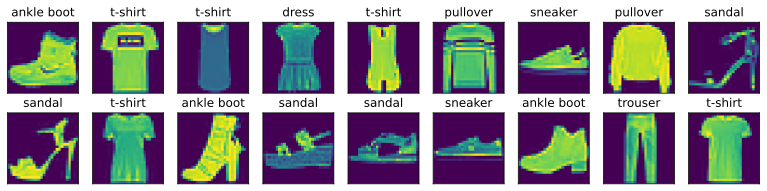

In [39]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [40]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [1]:
# timer = d2l.Timer()
# for X, y in train_iter:
#     continue
# f'{timer.stop():.2f} sec'

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

### 3.6 softmax回归的从零开始实现

In [63]:
import torch
import utils
import importlib
importlib.reload(utils)
from IPython import display

batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size)

In [44]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [45]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax由三个步骤组成：

1. 对每个项求幂（使用exp）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$


In [46]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [47]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0357, 0.0283, 0.3793, 0.4669, 0.0898],
         [0.0333, 0.4523, 0.0694, 0.0563, 0.3888]]),
 tensor([1.0000, 1.0000]))

In [48]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [49]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [50]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [51]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [52]:
accuracy(y_hat, y) / len(y)

0.5

In [53]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [54]:
evaluate_accuracy(net, test_iter)

0.1229

In [55]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [56]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        utils.use_svg_display()
        self.fig, self.axes = utils.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: utils.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [57]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [58]:
lr = 0.1

def updater(batch_size):
    return utils.sgd([W, b], lr, batch_size)

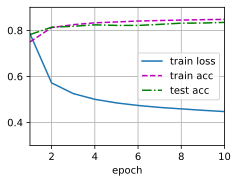

In [59]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

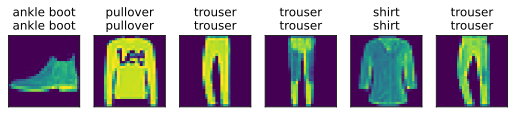

In [64]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = utils.get_fashion_mnist_labels(y)
    preds = utils.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    utils.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

### 3.7 简单实现

In [66]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size)

In [67]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);


In [68]:
loss = nn.CrossEntropyLoss(reduction='none')

In [69]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)


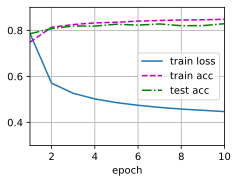

In [70]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
